# Kolmogorov-Arnold State-Space Model

Combining Kolmogorov-Arnold Networks (KANs) with state-space models to improve extrapolation performance is an innovative approach that leverages the strengths of both methodologies. This involves creating a hybrid architecture that combines KANs and state-space models, where the state-space model captures the temporal dynamics and the KAN handles the function approximation.

**State-Space Model (SSM)**: Use a state-space model to describe the evolution of the system's state over time. The state-space model typically consists of:

$$
\begin{aligned}
&h_{t+1} = A x_t + B u_t + w_t \\
&y_t = C x_t + D u_t + v_t  
\end{aligned}
$$

where $x_t$ is the state vector, $u_t$ is the input vector, $y_t$ is the output vector, and $w_t$ and $v_t$ are noise terms.

**KAN Integration**: Integrate a KAN to approximate the nonlinear functions involved in the state transition or the observation equations. For example, the state transition equation could be modified as:

$$
h_{t+1} = \sum_{i=1}^{2n+1} \phi_i \left( \sum_{j=1}^n \psi_{ij}(x_t, u_t) \right) + w_t
$$

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import KASSM

# Example Usage
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [16, 16]

model = KASSM(state_dim, input_dim, output_dim, kan_layers)

# Example data
batch_size = 1
state = torch.randn(batch_size, state_dim)
input = torch.randn(batch_size, input_dim)
observation_target = torch.randn(batch_size, output_dim)

from torchinfo import summary
print(summary(model, input_data=[state, input]))

# Forward pass
next_state, observation = model(state, input)

# loss
criterion = nn.MSELoss()
loss = criterion(next_state, state) + criterion(observation, observation_target)

print("Next State:", next_state)
print("Observation:", observation)
print("Loss:", loss.item())

Layer (type:depth-idx)                   Output Shape              Param #
KASSM                                    [1, 1]                    --
├─KAN: 1-1                               [1, 1]                    --
│    └─ModuleList: 2-1                   --                        --
│    │    └─KANLinear: 3-1               [1, 16]                   320
│    │    └─KANLinear: 3-2               [1, 16]                   2,560
│    │    └─KANLinear: 3-3               [1, 1]                    160
├─KAN: 1-2                               [1, 1]                    --
│    └─ModuleList: 2-2                   --                        --
│    │    └─KANLinear: 3-4               [1, 16]                   320
│    │    └─KANLinear: 3-5               [1, 16]                   2,560
│    │    └─KANLinear: 3-6               [1, 1]                    160
Total params: 6,080
Trainable params: 6,080
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.00
Forward/backward pass size (MB):

# Forecasting task 

## Harmonic Oscillator

### KASSM

#### Plot Example Data

9 18 27
torch.Size([3, 9, 1]) torch.Size([3, 9, 1]) torch.Size([3, 9, 1])


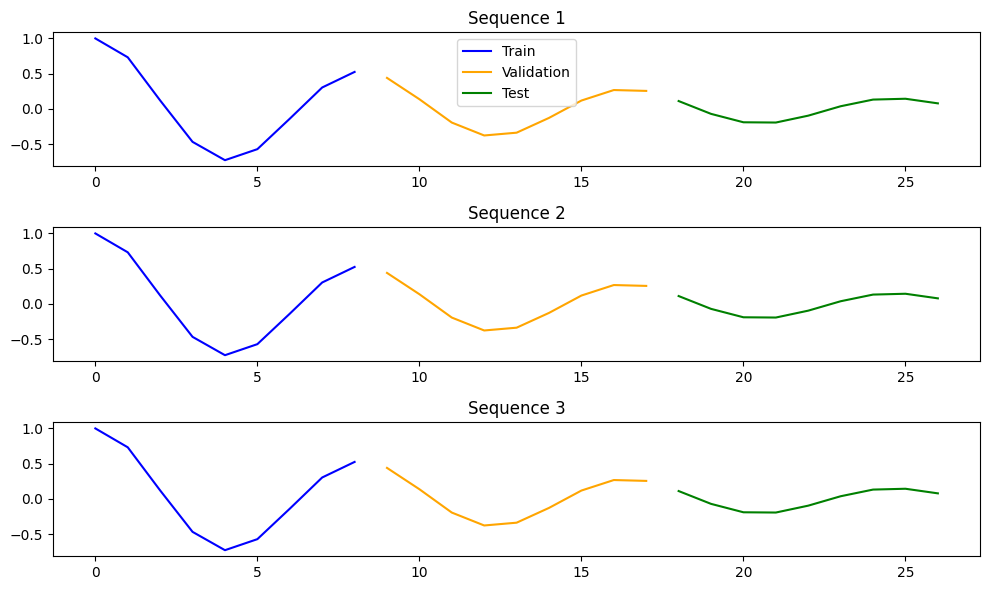

In [2]:
from utils import generate_oscillator_data, split_sequences, plot_sequences
num_sequences = 3
total_seq_length = 3**3
t_l = 0.5 # total time length
train_split_point = total_seq_length//3
test_split_point = int(2*train_split_point)

print(train_split_point, test_split_point, total_seq_length)
sequences, times = generate_oscillator_data(0, t_l, total_seq_length, num_sequences, d=4, w0=40)
train_batch, val_batch, test_batch = split_sequences(sequences, train_split_point, test_split_point)

print(train_batch.shape, val_batch.shape, test_batch.shape)

plot_sequences(sequences, train_split_point, test_split_point)

#### Example Forward Pass & Loss Calculation

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import KASSM

# Example Usage
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [16, 16]

num_sequences = 3
total_seq_length = 3**6
t_l = 0.5
train_split_point = total_seq_length//8
test_split_point = int(2*train_split_point)

model = KASSM(state_dim, input_dim, output_dim, kan_layers)

# Example data
batch_size = 1
sequences, times = generate_oscillator_data(0, t_l, total_seq_length, num_sequences, d=4, w0=40)
data = torch.concat([sequences, times], dim=-1)
train_batch, val_batch, test_batch = split_sequences(data, train_split_point, test_split_point)

# generate inputs and states
state = train_batch[:, :, 0].reshape(-1, state_dim)
input = train_batch[:, :, 1].reshape(-1, input_dim)


from torchinfo import summary
print(summary(model, input_data=[state, input]))

# Forward pass
next_state, observation = model(state, input)

# loss
criterion = nn.MSELoss()
loss = criterion(next_state, state) + criterion(observation, observation_target)

print("Next State:", next_state.shape)
print("Observation:", observation.shape)
print("Loss:", loss.item())

TypeError: generate_oscillator_data() got multiple values for argument 'd'

#### Training Loop

Train Seq Length 243, Epoch 10, Train Loss: 2.316e-01, Val Loss: 3.260e-02, Test Loss: 8.503e-03
Train Seq Length 243, Epoch 20, Train Loss: 1.057e-01, Val Loss: 1.847e-02, Test Loss: 5.238e-03
Train Seq Length 243, Epoch 30, Train Loss: 1.814e-02, Val Loss: 1.032e-01, Test Loss: 3.573e-02
Train Seq Length 243, Epoch 40, Train Loss: 1.785e-02, Val Loss: 2.157e-01, Test Loss: 8.611e-02
Train Seq Length 243, Epoch 50, Train Loss: 7.930e-03, Val Loss: 1.443e-01, Test Loss: 5.625e-02
Train Seq Length 243, Epoch 60, Train Loss: 7.020e-03, Val Loss: 1.062e-01, Test Loss: 4.127e-02
Train Seq Length 243, Epoch 70, Train Loss: 4.969e-03, Val Loss: 1.195e-01, Test Loss: 4.744e-02
Train Seq Length 243, Epoch 80, Train Loss: 4.086e-03, Val Loss: 1.315e-01, Test Loss: 5.230e-02
Train Seq Length 243, Epoch 90, Train Loss: 3.154e-03, Val Loss: 1.198e-01, Test Loss: 4.694e-02
Train Seq Length 243, Epoch 100, Train Loss: 2.453e-03, Val Loss: 1.127e-01, Test Loss: 4.325e-02
Train Seq Length 243, Epoch 1

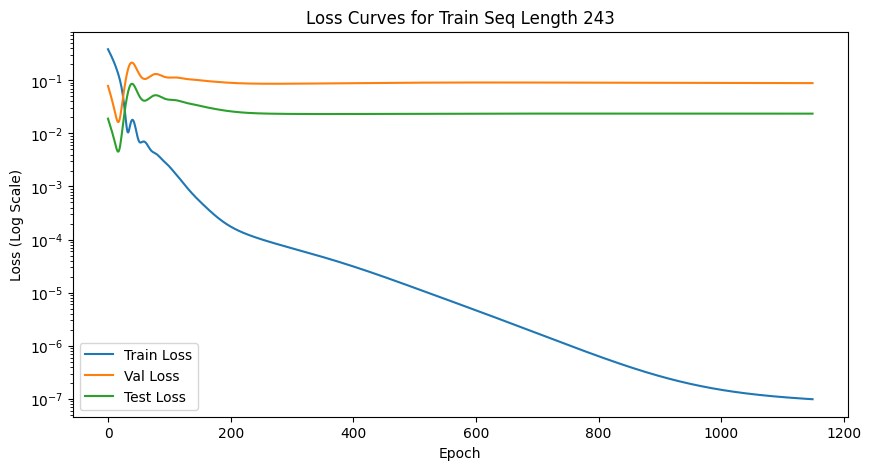

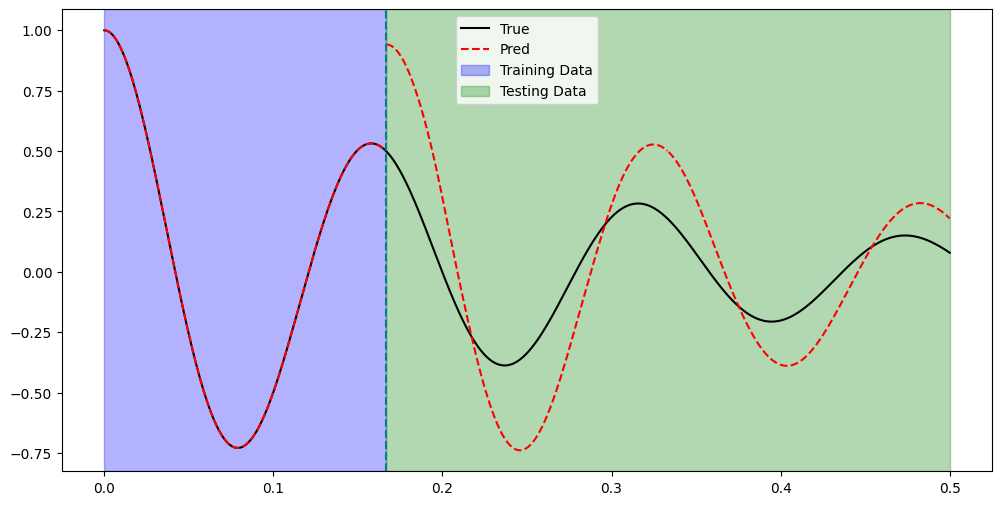

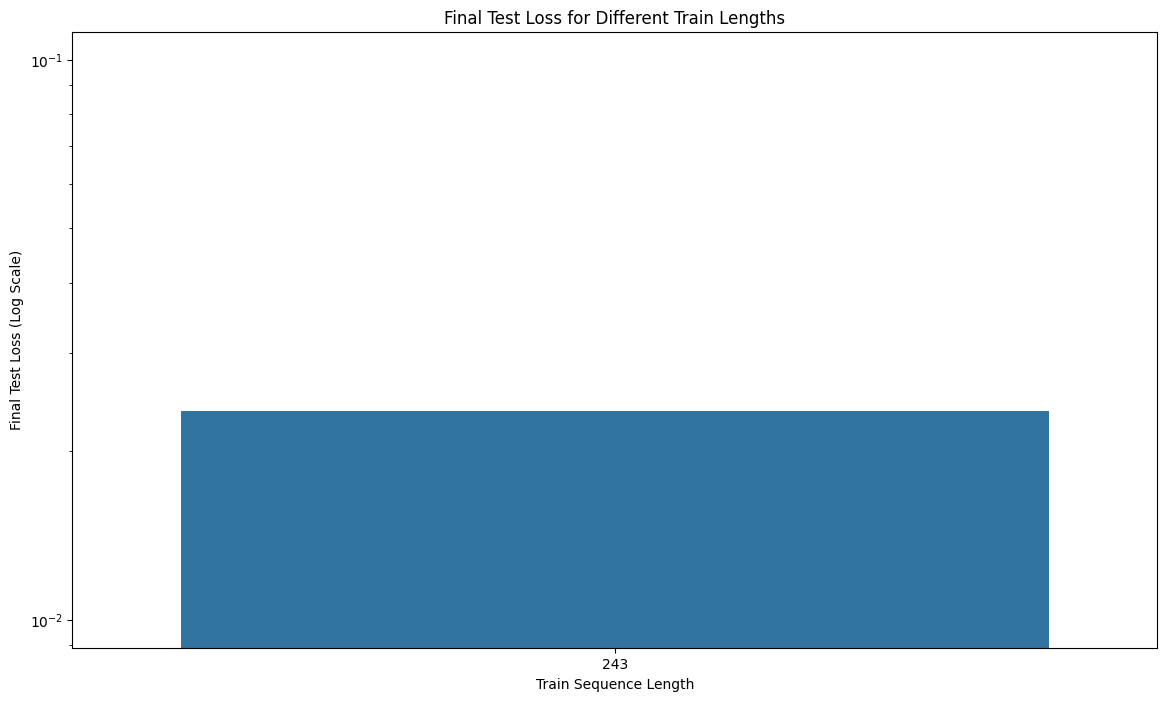

Train Seq Length 243:
  Final Train Loss: 9.833e-08
  Final Val Loss: 8.862e-02
  Final Test Loss: 2.358e-02


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from models import KASSM
from utils import generate_oscillator_data, plot_loss_curves, split_sequences

# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]
batch_size = 1
num_sequences = 1
total_seq_length = 3**6
t_l = 0.5
train_split_points = [total_seq_length//3]  # Different lengths of training sequences

convergence_std_threshold = 1e-4  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 1000


d, w0 = 4, 40

# Initialize performance data dictionary
performance_data = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for train_split_point in train_split_points:

    test_split_point = int(2*train_split_point)
    sequences, times = generate_oscillator_data(0, t_l, total_seq_length, num_sequences, d=4, w0=40)
    data = torch.concat([sequences, times], dim=-1)
    train_batch, val_batch, test_batch = split_sequences(data, train_split_point, test_split_point)
    train_batch, val_batch, test_batch = train_batch.to(device), val_batch.to(device), test_batch.to(device)

    
    model = KASSM(state_dim, input_dim, output_dim, kan_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    

    train_losses = []
    val_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    ft_idx = 0
    t_idx = 1

    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        
        # idx 0 = f(t), idx 1 = t        
        input = train_batch[:, :, ft_idx].reshape(-1, input_dim) # current f(t)
        target1 = train_batch[:, :, ft_idx].reshape(-1, output_dim) # t --> f(t) loss
        target2 = val_batch[:, :, ft_idx].reshape(-1, output_dim) # t --> f(t+1) loss

        state = val_batch[:, :, ft_idx].reshape(-1, state_dim)
        # target_state1 = train_batch[:, :, t_idx].reshape(-1, state_dim) # t
        target_state2 = val_batch[:, :, t_idx].reshape(-1, state_dim) # t+1

        
        next_state, observation = model(state, input)
        # .1*criterion(observation, target2)
        # .1*criterion(next_state, target_state2)
        loss = criterion(next_state, target2) + criterion(observation, target1)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():

            # generate val inputs and states
            val_state = train_batch[:, :, ft_idx].reshape(-1, state_dim)
            val_input = train_batch[:, :, ft_idx].reshape(-1, input_dim)
            val_target = val_batch[:, :, ft_idx].reshape(-1, output_dim)
            
            val_state = val_state.reshape(-1, state_dim)
            val_input = val_input.reshape(-1, input_dim)
            
            _, val_observation = model(val_state, val_input)

            val_loss = criterion(val_observation, val_target.reshape(-1, output_dim))
            val_losses.append(val_loss.item())

            # generate inputs and states
            test_state = val_batch[:, :, ft_idx].reshape(-1, state_dim)
            test_input = val_batch[:, :, ft_idx].reshape(-1, input_dim)
            test_target = test_batch[:, :, ft_idx].reshape(-1, output_dim)
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            test_loss = criterion(test_observation, test_target.reshape(-1, output_dim))
            test_losses.append(test_loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Train Seq Length {train_split_point}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Val Loss: {val_loss.item():.3e}, Test Loss: {test_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_split_point,
        "final_train_loss": train_losses[-1],
        "final_val_loss": val_losses[-1],
        "final_test_loss": test_losses[-1]
    })
    
    # Plotting functions
    def plot_loss_curves(train_losses, test_losses, val_losses, train_seq_length):
        train_losses = np.array(train_losses)
        test_losses = np.array(test_losses)
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.yscale('log')
        plt.title(f"Loss Curves for Train Seq Length {train_seq_length}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (Log Scale)")
        plt.legend()
        plt.show()

    # Plot loss curves
    plot_loss_curves(train_losses, test_losses, val_losses, train_split_point)


    
    trn_time_plt = train_batch[:, :, t_idx].reshape(-1, 1).cpu().numpy()
    val_time_plt = val_batch[:, :, t_idx].reshape(-1, 1).cpu().numpy()
    tst_time_plt = test_batch[:, :, t_idx].reshape(-1, 1).cpu().numpy()

    trn_true_plt = train_batch[:, :, ft_idx].reshape(-1, 1).cpu().numpy()
    val_true_plt = val_batch[:, :, ft_idx].reshape(-1, 1).cpu().numpy()
    tst_true_plt = test_batch[:, :, ft_idx].reshape(-1, 1).cpu().numpy()

    trn_pred_plt = observation.reshape(-1, 1).detach().cpu().numpy()
    val_pred_plt = val_observation.reshape(-1, 1).detach().cpu().numpy()
    tst_pred_plt = test_observation.reshape(-1, 1).detach().cpu().numpy()

    
    plt.figure(figsize=(12, 6))

    plt.plot(trn_time_plt, trn_true_plt, color='black', linestyle='-', label="True")
    plt.plot(val_time_plt, val_true_plt, color='black', linestyle='-')
    plt.plot(tst_time_plt, tst_true_plt, color='black', linestyle='-')

    plt.plot(trn_time_plt, trn_pred_plt, color='red', linestyle='--', label="Pred")
    plt.plot(val_time_plt, val_pred_plt, color='red', linestyle='--')
    plt.plot(tst_time_plt, tst_pred_plt, color='red', linestyle='--')

    vline = (trn_time_plt[-1]+val_time_plt[0])/2
    plt.axvspan(0, vline[0], alpha=0.3, color='blue', label="Training Data")
    plt.axvspan(vline[0], tst_time_plt[-1][0], alpha=0.3, color='green', label="Testing Data")
    plt.axvline(vline, color='teal', linestyle='--')

    plt.legend()
    plt.show()

    # Convert performance data to a DataFrame for seaborn plotting
    performance_df = pd.DataFrame(performance_data)

    plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_test_loss", data=performance_df)
    plt.title("Final Test Loss for Different Train Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Test Loss (Log Scale)")
    plt.show()




    # Print performance data for inspection
    for data in performance_data:
        print(f"Train Seq Length {data['train_seq_length']}:")
        print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
        print(f"  Final Val Loss: {data['final_val_loss']:.3e}")
        print(f"  Final Test Loss: {data['final_test_loss']:.3e}")

    # Save performance data to a file if needed
    import json
    with open("performance_data.json", "w") as f:
        json.dump(performance_data, f)


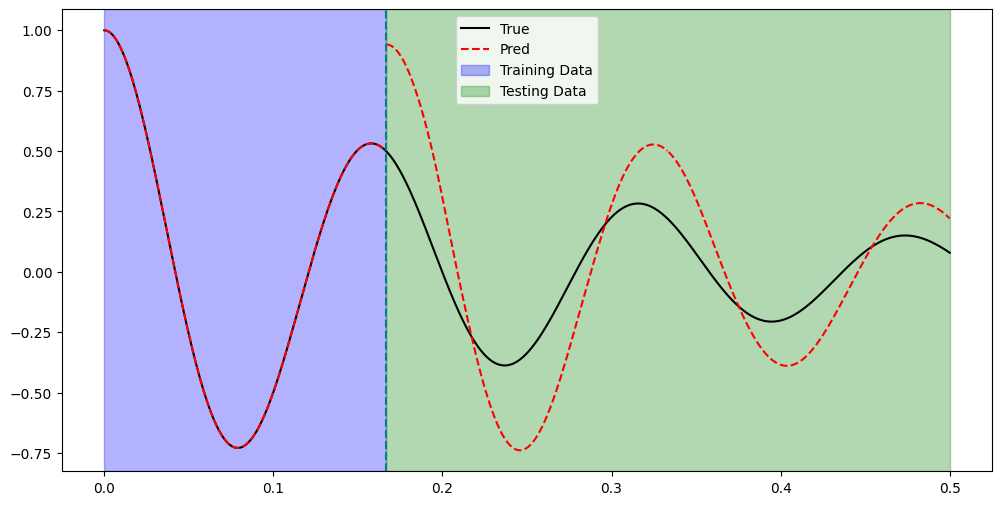

In [5]:
plt.figure(figsize=(12, 6))

plt.plot(trn_time_plt, trn_true_plt, color='black', linestyle='-', label="True")
plt.plot(val_time_plt, val_true_plt, color='black', linestyle='-')
plt.plot(tst_time_plt, tst_true_plt, color='black', linestyle='-')

plt.plot(trn_time_plt, trn_pred_plt, color='red', linestyle='--', label="Pred")
plt.plot(val_time_plt, val_pred_plt, color='red', linestyle='--')
plt.plot(tst_time_plt, tst_pred_plt, color='red', linestyle='--')

vline = (trn_time_plt[-1]+val_time_plt[0])/2
plt.axvspan(0, vline[0], alpha=0.3, color='blue', label="Training Data")
plt.axvspan(vline[0], tst_time_plt[-1][0], alpha=0.3, color='green', label="Testing Data")
plt.axvline(vline, color='teal', linestyle='--')

plt.legend()
plt.show()

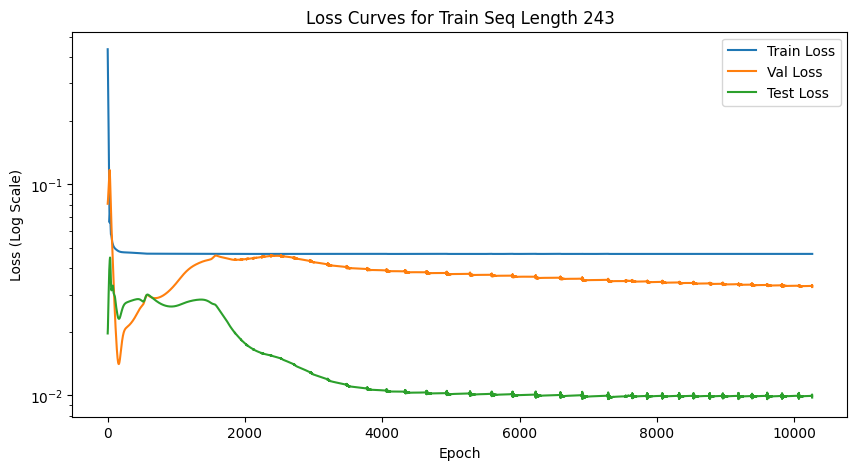

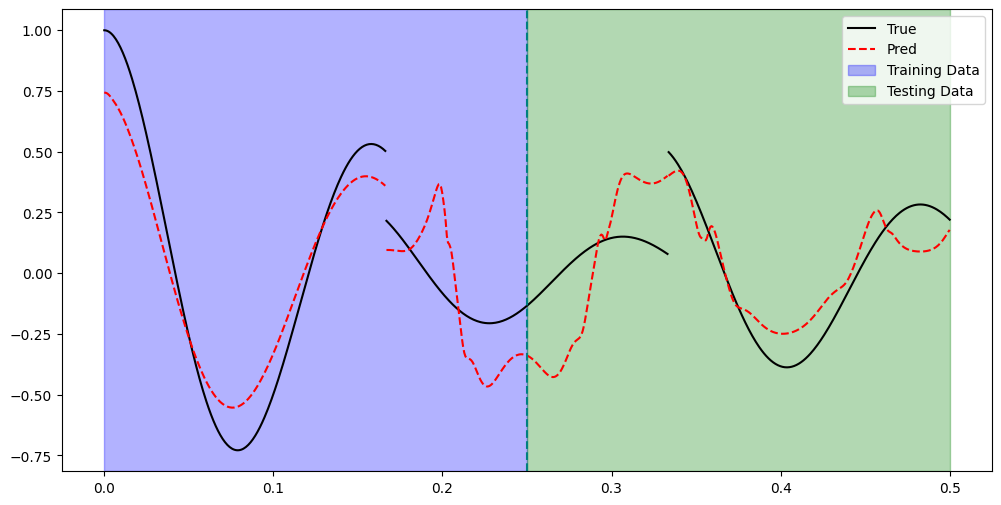

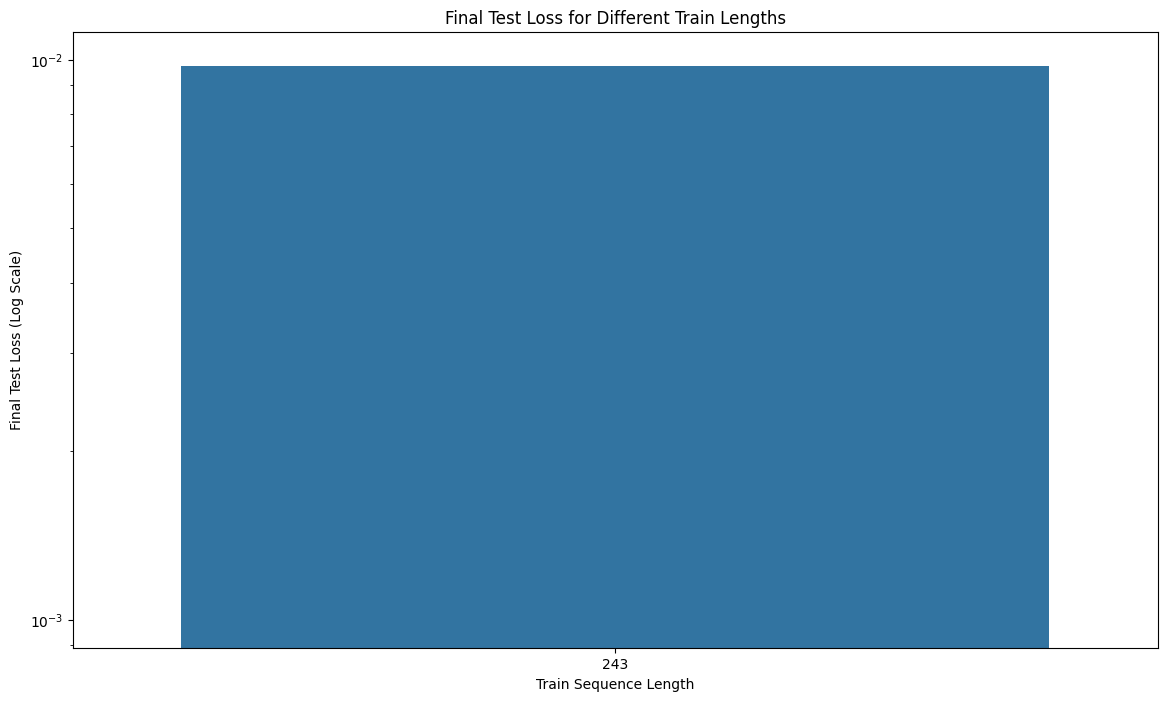

Train Seq Length 243:
  Final Train Loss: 4.672e-02
  Final Val Loss: 3.255e-02
  Final Test Loss: 9.750e-03
Train Seq Length 243:
  Final Train Loss: 4.672e-02
  Final Val Loss: 3.255e-02
  Final Test Loss: 9.750e-03
Train Seq Length 243:
  Final Train Loss: 4.672e-02
  Final Val Loss: 3.255e-02
  Final Test Loss: 9.750e-03
Train Seq Length 243:
  Final Train Loss: 4.672e-02
  Final Val Loss: 3.255e-02
  Final Test Loss: 9.750e-03
Train Seq Length 243:
  Final Train Loss: 4.672e-02
  Final Val Loss: 3.255e-02
  Final Test Loss: 9.750e-03


# Experimental Loop - (PI-){NN, KAN, KASSM}

Train Seq Length 10, Extrapolation Length 110, Epoch 10, Train Loss: 7.657e-01, Test Loss: 3.668e-01, Extrapolation Loss: 2.460e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 20, Train Loss: 6.616e-01, Test Loss: 3.224e-01, Extrapolation Loss: 2.254e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 30, Train Loss: 5.502e-01, Test Loss: 2.738e-01, Extrapolation Loss: 2.074e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 40, Train Loss: 4.194e-01, Test Loss: 2.134e-01, Extrapolation Loss: 1.905e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 50, Train Loss: 2.707e-01, Test Loss: 1.402e-01, Extrapolation Loss: 1.824e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 60, Train Loss: 1.284e-01, Test Loss: 6.631e-02, Extrapolation Loss: 2.225e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 70, Train Loss: 3.643e-02, Test Loss: 1.735e-02, Extrapolation Loss: 3.986e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 80, Train Loss: 1.298e-

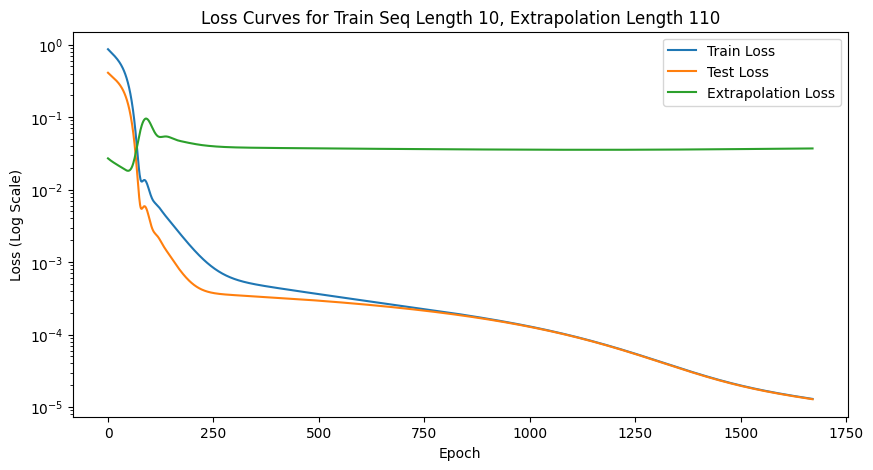

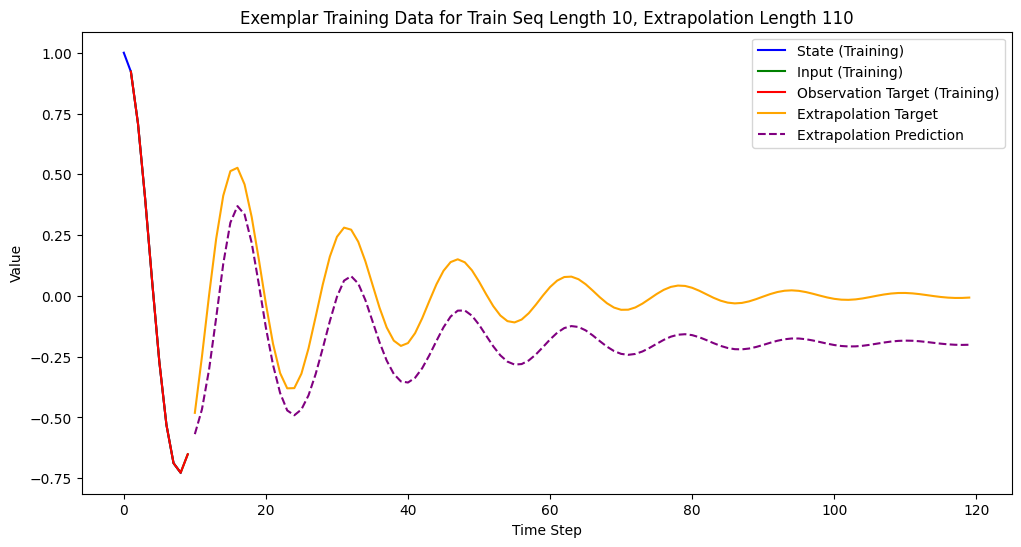

Train Seq Length 15, Extrapolation Length 105, Epoch 10, Train Loss: 5.834e-01, Test Loss: 2.591e-01, Extrapolation Loss: 1.980e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 20, Train Loss: 5.182e-01, Test Loss: 2.286e-01, Extrapolation Loss: 1.829e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 30, Train Loss: 4.390e-01, Test Loss: 1.921e-01, Extrapolation Loss: 1.649e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 40, Train Loss: 3.379e-01, Test Loss: 1.462e-01, Extrapolation Loss: 1.385e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 50, Train Loss: 2.186e-01, Test Loss: 9.238e-02, Extrapolation Loss: 1.021e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 60, Train Loss: 1.067e-01, Test Loss: 4.447e-02, Extrapolation Loss: 6.929e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 70, Train Loss: 4.478e-02, Test Loss: 2.297e-02, Extrapolation Loss: 5.749e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 80, Train Loss: 3.593e-

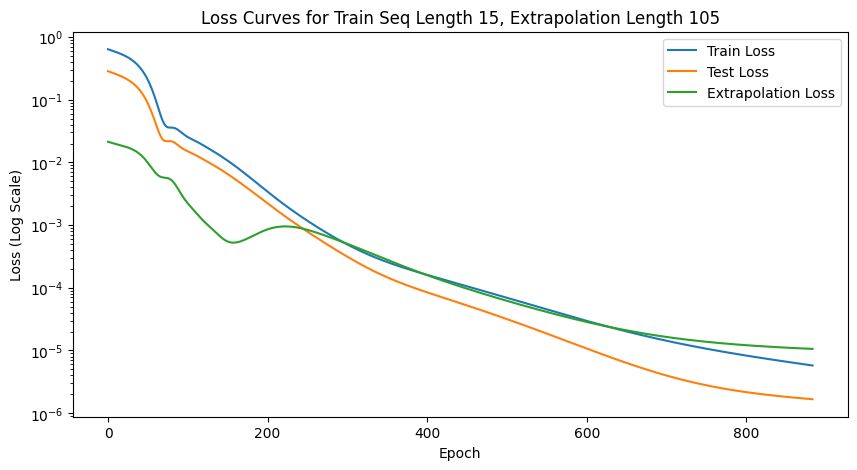

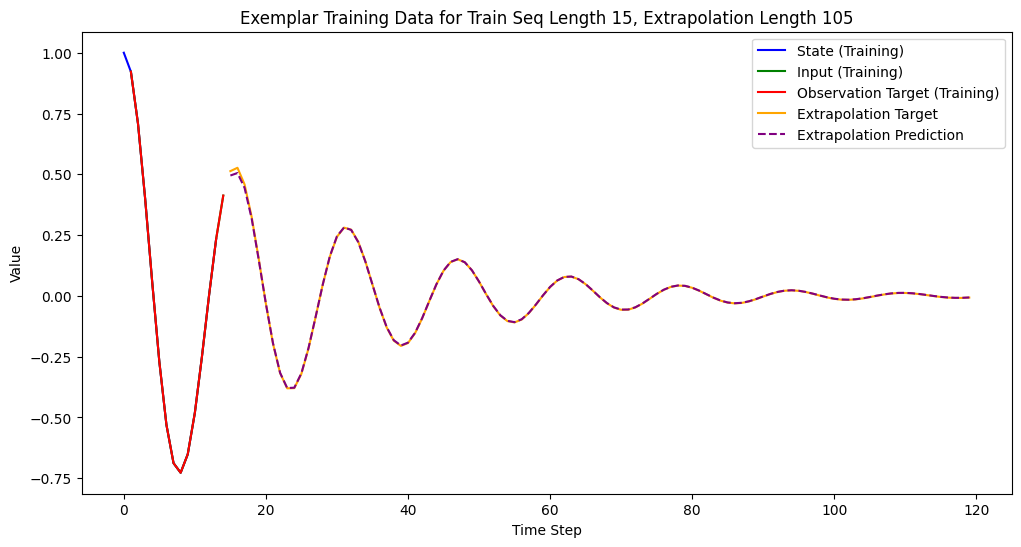

Train Seq Length 30, Extrapolation Length 90, Epoch 10, Train Loss: 3.840e-01, Test Loss: 1.710e-01, Extrapolation Loss: 6.681e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 20, Train Loss: 3.409e-01, Test Loss: 1.468e-01, Extrapolation Loss: 5.787e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 30, Train Loss: 2.871e-01, Test Loss: 1.172e-01, Extrapolation Loss: 4.667e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 40, Train Loss: 2.181e-01, Test Loss: 8.141e-02, Extrapolation Loss: 3.364e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 50, Train Loss: 1.377e-01, Test Loss: 4.460e-02, Extrapolation Loss: 2.406e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 60, Train Loss: 6.588e-02, Test Loss: 2.004e-02, Extrapolation Loss: 2.880e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 70, Train Loss: 2.994e-02, Test Loss: 1.509e-02, Extrapolation Loss: 4.432e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 80, Train Loss: 2.460e-02, Test

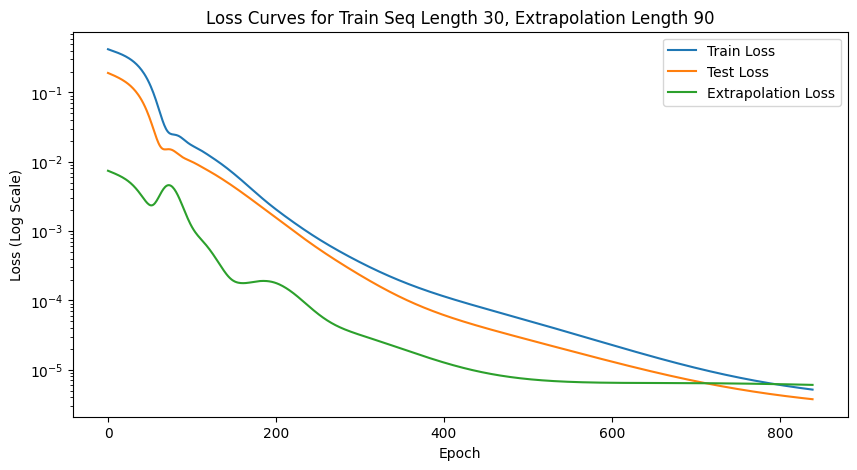

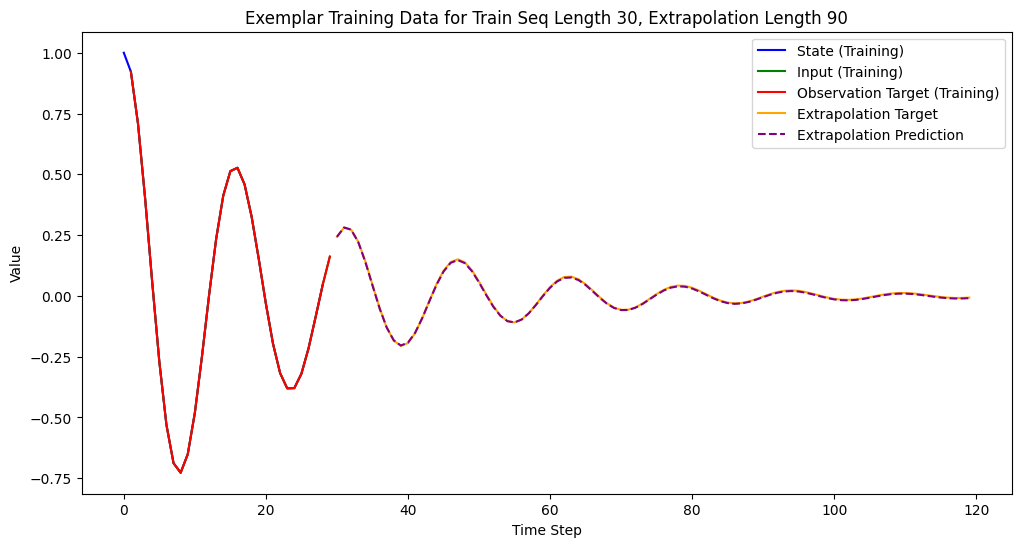

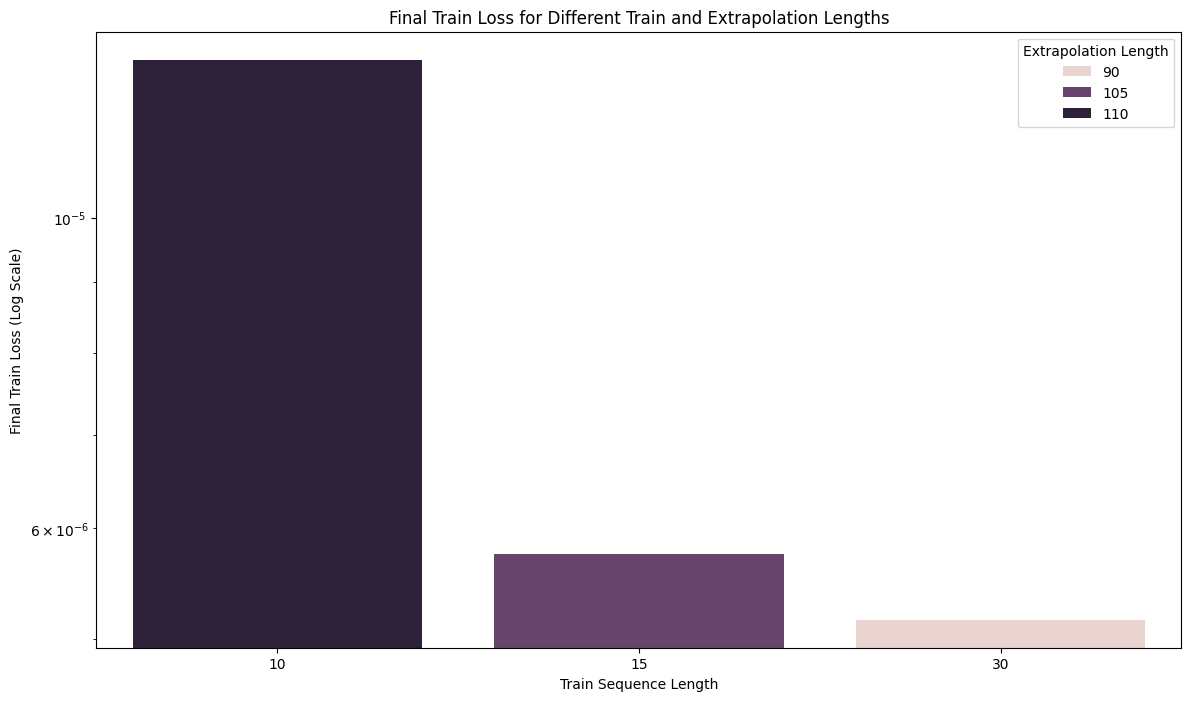

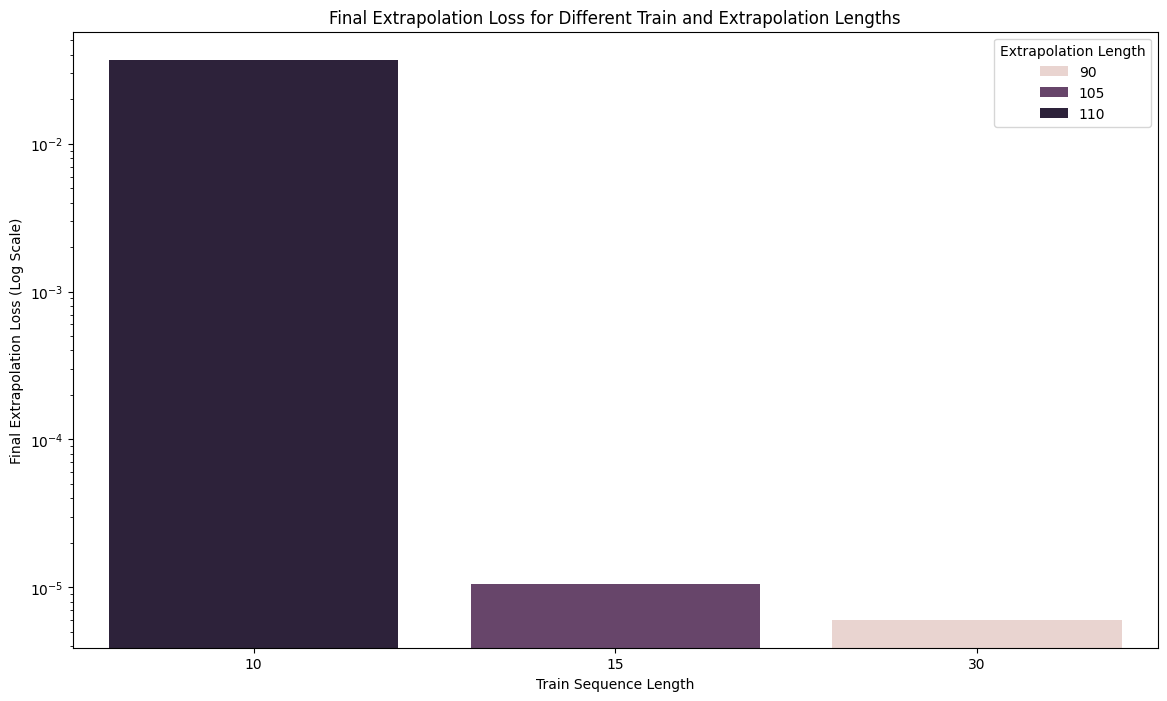

Train Seq Length 10, Extrapolation Length 110:
  Final Train Loss: 1.296e-05
  Final Test Loss: 1.284e-05
  Final Extrapolation Loss: 3.700e-02
Train Seq Length 15, Extrapolation Length 105:
  Final Train Loss: 5.754e-06
  Final Test Loss: 1.666e-06
  Final Extrapolation Loss: 1.058e-05
Train Seq Length 30, Extrapolation Length 90:
  Final Train Loss: 5.164e-06
  Final Test Loss: 3.753e-06
  Final Extrapolation Loss: 6.043e-06


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
from models import KASSM

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length / 100, seq_length)
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times


def train(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    performance_data = []

    for train_seq_length in config['train_seq_lengths']:
        extrapolation_length = config['total_seq_length'] - train_seq_length
        
        model = KASSM(config['state_dim'], config['input_dim'], config['output_dim'], config['kan_layers']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.MSELoss()
        
        train_data, train_times = generate_oscillator_data(config['total_seq_length'], config['num_sequences'], config['d'], config['w0'])
        train_data, train_times = train_data.to(device), train_times.to(device)
        
        train_losses = []
        test_losses = []
        patience_counter = 0
        
        epoch = 0
        while patience_counter < config['patience']:
            model.train()
            optimizer.zero_grad()
            
            state = train_data[:, :train_seq_length-1, :]
            input = train_data[:, 1:train_seq_length, :]
            observation_target = train_data[:, 1:train_seq_length, :]
            
            state = state.reshape(-1, config['state_dim'])
            input = input.reshape(-1, config['input_dim'])
            observation_target = observation_target.reshape(-1, config['output_dim'])
            
            next_state, observation = model(state, input)
            loss = criterion(next_state, state) + criterion(observation, observation_target)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

            if len(train_losses) > config['n_pts']:
                recent_losses = train_losses[-config['n_pts']:]
                std_recent_losses = np.std(recent_losses)
                if std_recent_losses < config['convergence_std_threshold']:
                    patience_counter += 1
                else:
                    patience_counter = 0
            else:
                patience_counter = 0
            
            model.eval()
            with torch.no_grad():
                test_state = train_data[:, :train_seq_length-1, :]
                test_input = train_data[:, 1:train_seq_length, :]
                
                test_state = test_state.reshape(-1, config['state_dim'])
                test_input = test_input.reshape(-1, config['input_dim'])
                
                _, test_observation = model(test_state, test_input)
                
                extrap_state = train_data[:, train_seq_length-1:-1, :]
                extrap_input = train_data[:, train_seq_length:, :]
                extrap_target = train_data[:, train_seq_length:, :]
                
                extrap_state = extrap_state.reshape(-1, config['state_dim'])
                extrap_input = extrap_input.reshape(-1, config['input_dim'])
                extrap_target = extrap_target.reshape(-1, config['output_dim'])
                
                _, extrap_observation = model(extrap_state, extrap_input)
                
                test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, config['output_dim']))
                extrapolation_loss = criterion(extrap_observation, extrap_target)
                test_losses.append((test_loss.item(), extrapolation_loss.item()))

            if (epoch + 1) % config['log_interval'] == 0:
                print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
            
            epoch += 1
        
        performance_data.append({
            "train_seq_length": train_seq_length,
            "extrapolation_length": extrapolation_length,
            "final_train_loss": train_losses[-1],
            "final_test_loss": test_losses[-1][0],
            "final_extrapolation_loss": test_losses[-1][1]
        })
        
        train_losses = np.array(train_losses)
        test_losses = np.array(test_losses)
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses[:, 0], label="Test Loss")
        plt.plot(test_losses[:, 1], label="Extrapolation Loss")
        plt.yscale('log')
        plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (Log Scale)")
        plt.legend()
        plt.show()
        
        exemplar_index = 0
        exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
        exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
        exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
        exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

        model.eval()
        with torch.no_grad():
            extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
            extrap_input = train_data[exemplar_index, train_seq_length:, :]
            
            extrap_state = extrap_state.reshape(-1, config['state_dim'])
            extrap_input = extrap_input.reshape(-1, config['input_dim'])
            
            _, extrap_prediction = model(extrap_state, extrap_input)
            extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

        plt.figure(figsize=(12, 6))
        plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
        plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
        plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
        plt.plot(range(train_seq_length, config['total_seq_length']), exemplar_extrapolation, label="Extrapolation Target", color='orange')
        plt.plot(range(train_seq_length, config['total_seq_length']), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
        plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    
    performance_df = pd.DataFrame(performance_data)

    plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
    plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Train Loss (Log Scale)")
    plt.legend(title="Extrapolation Length")
    plt.show()

    plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
    plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Extrapolation Loss (Log Scale)")
    plt.legend(title="Extrapolation Length")
    plt.show()

    for data in performance_data:
        print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
        print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
        print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
        print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

    with open(config['performance_data_file'], "w") as f:
        json.dump(performance_data, f)

config = {
    'state_dim': 1,
    'input_dim': 1,
    'output_dim': 1,
    'kan_layers': [16, 16],
    'batch_size': 10,
    'num_sequences': 10,
    'total_seq_length': 120,
    'train_seq_lengths': [10, 15, 30],
    'convergence_std_threshold': 1e-6,
    'patience': 13,
    'n_pts': 100,
    'd': 4,
    'w0': 40,
    'learning_rate': 1e-3,
    'log_interval': 10,
    'performance_data_file': "performance_data.json"
}

train(config)


In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import time
import json

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

def generate_oscillator_data(seq_length, num_sequences, d, w0, noise_std=0.0):
    t = torch.linspace(0, seq_length / 100, seq_length)
    data = oscillator(d, w0, t).unsqueeze(-1)
    if noise_std > 0:
        noise = noise_std * torch.randn_like(data)
        data += noise
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

def create_experiment_directory(base_path="experiments"):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    run_timestamp = str(int(time.time()))
    run_directory = os.path.join(base_path, run_timestamp)
    os.makedirs(run_directory)
    return run_directory

def save_figure(fig, filepath):
    fig.savefig(filepath, bbox_inches='tight')
    plt.close(fig)

def train(config):
    run_directory = create_experiment_directory()
    
    # Save config to the run directory
    with open(os.path.join(run_directory, "config.json"), "w") as config_file:
        json.dump(config, config_file, indent=4)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    performance_data = []

    for train_seq_length in config['train_seq_lengths']:
        validation_length = (config['total_seq_length'] - train_seq_length) // 2
        test_length = config['total_seq_length'] - train_seq_length - validation_length
        
        model = KASSM(config['state_dim'], config['input_dim'], config['output_dim'], config['kan_layers']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.MSELoss()
        
        # # Generate noisy training data
        # train_data, _ = generate_oscillator_data(train_seq_length, config['num_sequences'], config['d'], config['w0'], noise_std=config['noise_std'])
        # train_data = train_data.to(device)

        # Generate validation data (no noise)
        val_data, _ = generate_oscillator_data(validation_length, config['num_sequences'], config['d'], config['w0'])
        val_data = val_data.to(device)

        # Generate test data (no noise)
        test_data, _ = generate_oscillator_data(test_length, config['num_sequences'], config['d'], config['w0'])
        test_data = test_data.to(device)
        
        train_losses = []
        val_losses = []
        
        epoch = 0
        patience_counter = 0
        while patience_counter < config['patience']:
            model.train()
            optimizer.zero_grad()

            # Generate noisy training data
            train_data, _ = generate_oscillator_data(train_seq_length, config['num_sequences'], config['d'], config['w0'], noise_std=config['noise_std'])
            train_data = train_data.to(device)
            
            state = train_data[:, :train_seq_length-1, :]
            input = train_data[:, 1:train_seq_length, :]
            observation_target = train_data[:, 1:train_seq_length, :]
            
            state = state.reshape(-1, config['state_dim'])
            input = input.reshape(-1, config['input_dim'])
            observation_target = observation_target.reshape(-1, config['output_dim'])
            
            next_state, observation = model(state, input)
            loss = criterion(next_state, state) + criterion(observation, observation_target)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

            if len(train_losses) > config['n_pts']:
                recent_losses = train_losses[-config['n_pts']:]
                std_recent_losses = np.std(recent_losses)
                if std_recent_losses < config['convergence_std_threshold']:
                    patience_counter += 1
                else:
                    patience_counter = 0
            
            model.eval()
            with torch.no_grad():
                val_state = val_data[:, :validation_length-1, :]
                val_input = val_data[:, 1:validation_length, :]
                
                val_state = val_state.reshape(-1, config['state_dim'])
                val_input = val_input.reshape(-1, config['input_dim'])
                
                _, val_observation = model(val_state, val_input)
                val_loss = criterion(val_observation, val_data[:, 1:validation_length, :].reshape(-1, config['output_dim']))
                val_losses.append(val_loss.item())

            if (epoch + 1) % config['log_interval'] == 0:
                print(f"Train Seq Length {train_seq_length}, Validation Length {validation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Val Loss: {val_loss.item():.3e}")
            
            epoch += 1
        
        # Generate final test data
        model.eval()
        with torch.no_grad():
            test_state = test_data[:, :test_length-1, :]
            test_input = test_data[:, 1:test_length, :]
            
            test_state = test_state.reshape(-1, config['state_dim'])
            test_input = test_input.reshape(-1, config['input_dim'])
            
            _, test_observation = model(test_state, test_input)
            test_loss = criterion(test_observation, test_data[:, 1:test_length, :].reshape(-1, config['output_dim']))
        
        performance_data.append({
            "train_seq_length": train_seq_length,
            "validation_length": validation_length,
            "test_length": test_length,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "final_test_loss": test_loss.item()
        })
        
        train_losses = np.array(train_losses)
        val_losses = np.array(val_losses)
        
        fig = plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.yscale('log')
        plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Validation Length {validation_length}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (Log Scale)")
        plt.legend()
        save_figure(fig, os.path.join(run_directory, f"loss_curves_{train_seq_length}.png"))
    
    performance_df = pd.DataFrame(performance_data)

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_train_loss", hue="validation_length", data=performance_df)
    plt.title("Final Train Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Train Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_train_loss.png"))

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_val_loss", hue="validation_length", data=performance_df)
    plt.title("Final Validation Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Validation Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_val_loss.png"))

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_test_loss", hue="validation_length", data=performance_df)
    plt.title("Final Test Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Test Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_test_loss.png"))

    performance_df.to_csv(os.path.join(run_directory, "performance_data.csv"), index=False)

    with open(os.path.join(run_directory, "performance_data.json"), "w") as f:
        json.dump(performance_data, f)

    # Within the train function, after model evaluation and performance data logging

    # Plot exemplar data for training, validation, and test sets
    exemplar_index = 0

    # Extract data for plotting
    train_example = train_data[exemplar_index, :train_seq_length, :].squeeze().cpu().numpy()
    val_example = val_data[exemplar_index, :validation_length, :].squeeze().cpu().numpy()
    test_example = test_data[exemplar_index, :test_length, :].squeeze().cpu().numpy()

    # Generate time axes for each segment
    train_time = np.linspace(0, train_seq_length / 100, train_seq_length)
    val_time = np.linspace(train_seq_length / 100, (train_seq_length + validation_length) / 100, validation_length)
    test_time = np.linspace((train_seq_length + validation_length) / 100, config['total_seq_length'] / 100, test_length)

    # Combine all sequences and time axes for plotting
    combined_example = np.concatenate((train_example, val_example, test_example), axis=0)
    combined_time = np.concatenate((train_time, val_time, test_time))

    # Model predictions for the entire sequence (training, validation, and test)
    model.eval()
    with torch.no_grad():
        combined_state = torch.cat([train_data[exemplar_index, :train_seq_length-1, :],
                                    val_data[exemplar_index, :validation_length-1, :],
                                    test_data[exemplar_index, :test_length-1, :]], dim=0)
        combined_input = torch.cat([train_data[exemplar_index, 1:train_seq_length, :],
                                    val_data[exemplar_index, 1:validation_length, :],
                                    test_data[exemplar_index, 1:test_length, :]], dim=0)

        combined_state = combined_state.reshape(-1, config['state_dim']).to(device)
        combined_input = combined_input.reshape(-1, config['input_dim']).to(device)
        
        _, combined_prediction = model(combined_state, combined_input)
        combined_prediction = combined_prediction.cpu().numpy().reshape(-1)

    # Adjust combined time axis for predictions (one step ahead)
    combined_time_predictions = np.concatenate((train_time[1:], val_time[1:], test_time[1:]))

    # Plotting the combined data
    fig = plt.figure(figsize=(12, 6))
    plt.plot(combined_time, combined_example, label="True Data", color='blue')
    plt.plot(combined_time_predictions, combined_prediction, label="Model Prediction", color='red', linestyle='--')
    plt.axvline(x=train_seq_length / 100, color='green', linestyle=':', label='End of Training')
    plt.axvline(x=(train_seq_length + validation_length) / 100, color='orange', linestyle=':', label='End of Validation')
    plt.title(f"Training, Validation, and Test Data with Model Prediction")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    save_figure(fig, os.path.join(run_directory, "combined_data_plot.png"))



config = {
    'state_dim': 1,
    'input_dim': 1,
    'output_dim': 1,
    'kan_layers': [16, 16],
    'batch_size': 10,
    'num_sequences': 10,
    'total_seq_length': 120,
    'train_seq_lengths': [10, 15],
    'convergence_std_threshold': 1e-3,
    'patience': 13,
    'n_pts': 100,
    'd': 4,
    'w0': 40,
    'learning_rate': 1e-3,
    'log_interval': 10,
    'noise_std': 0.1  # Standard deviation of noise for training data
}

train(config)


Train Seq Length 10, Validation Length 55, Epoch 10, Train Loss: 7.099e-01, Val Loss: 9.936e-02
Train Seq Length 10, Validation Length 55, Epoch 20, Train Loss: 6.239e-01, Val Loss: 8.987e-02
Train Seq Length 10, Validation Length 55, Epoch 30, Train Loss: 3.877e-01, Val Loss: 8.023e-02
Train Seq Length 10, Validation Length 55, Epoch 40, Train Loss: 3.792e-01, Val Loss: 6.683e-02
Train Seq Length 10, Validation Length 55, Epoch 50, Train Loss: 1.776e-01, Val Loss: 4.934e-02
Train Seq Length 10, Validation Length 55, Epoch 60, Train Loss: 6.905e-02, Val Loss: 3.424e-02
Train Seq Length 10, Validation Length 55, Epoch 70, Train Loss: 3.345e-02, Val Loss: 2.871e-02
Train Seq Length 10, Validation Length 55, Epoch 80, Train Loss: 2.048e-02, Val Loss: 2.702e-02
Train Seq Length 10, Validation Length 55, Epoch 90, Train Loss: 2.750e-02, Val Loss: 2.209e-02
Train Seq Length 10, Validation Length 55, Epoch 100, Train Loss: 1.124e-02, Val Loss: 2.017e-02
Train Seq Length 10, Validation Length 